In [3]:
import os
import rioxarray
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import os.path
from pathlib import Path
import csv
import math
from osgeo import gdal, ogr, osr, gdalconst

pd.set_option('display.max_columns', 500)

In [75]:
def tif_dict(strpath, masked=True, chunks=None, dsmatch=None):
    """
    Walks a directory of geotiffs and returns a dictionary of rioxarray DataArrays
    Args:
        strpath: directory name
        chunks: tuple of integers
        dsmatch: data array to match the directory of raster to
        masked: whether to mask by nodata, default is yes, pass masked=False if not desired
    Returns:
        a dictionary of rioxarrays
        
    Examples: 
       tif_dict(r'D:\BananaSplits')
       tif_dict(r'D:\BananaSplits', chunk=s(1,1024,1024))
    
    """

    check_dict = {}
    for root, dirs, files in os.walk(strpath):
        for file in files:
            if file.endswith('.tif'):
                print(file)
                if dsmatch is None:
                    if chunks is None:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file),masked=masked)    
                    else:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file), masked=masked, chunks=chunks)    
                else:
                    if chunks is None:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file), masked=masked).rio.reproject_match(dsmatch)    
                    else:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file), masked=masked, chunks=chunks).rio.reproject_match(dsmatch)    
                
    return check_dict

def location_sample(gdf, da, name_col):
    """
    Returns a dataframe of points sample from a DataArray by location at once
    
    Args:
        gdf: geodataframe of points
        da: DataArrau to sample:
        name_col: String to identify the location names
        
    Returns:
        Onshore location sample dataframe
    
    """

    lat = gdf.geometry.y.tolist()
    lon = gdf.geometry.x.tolist()
    xl = xr.DataArray(lon, dims=['location'],coords={"location":gdf[name_col].tolist()})
    yl = xr.DataArray(lat, dims=['location'],coords={"location":gdf[name_col].tolist()})
    
    dapt = da.sel(x=xl,y=yl,method="nearest")
    dfda = dapt.to_dataframe().reset_index()  
   
    return dfda



A good comparison piece would be: https://search.geoscience.nsw.gov.au/product/9233/7564550 in the Curnamona

here's a starting point comparison https://github.com/chudasama-bijal/QGIS-Plugin-Weights-of-Evidence-Model

An R version - https://github.com/GeoscienceAustralia/MPM-WofE

Get training data vector data - 1s

Choose mask layer if desired

Classes
- Favourable
- Unfavourable

Get list of evidence rasters

Studentized t contrast

Clip and make rasters the same details

Rasterise training data

Get count of data and not - e.g 1s and 0s in raster

Calculate weights
#633

Input weights rasters

calculate bayesian probs
#1590

In [5]:
## so possible exercise - convert the R version to python, possibly with robot assistance
## vectorize more in xarray

Borrow the test dataset from the Geoscience Australia example above by Arianne Ford

In [53]:
data = tif_dict(r'TESTDATA\\CalculateWeights')

Dist2Breccia.tif
Dist2Fault.tif
FaultDensity.tif
StratNo.tif


In [54]:
type(data)

dict

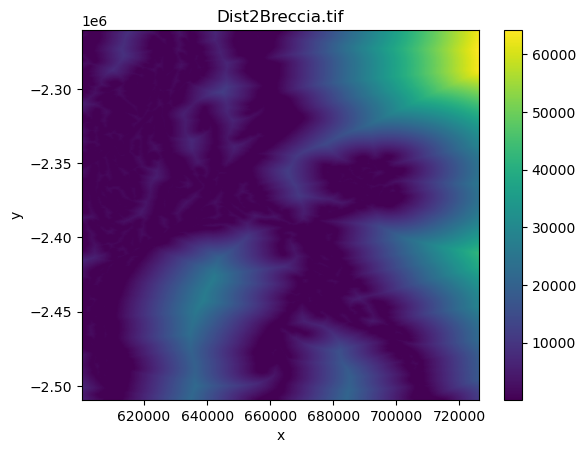

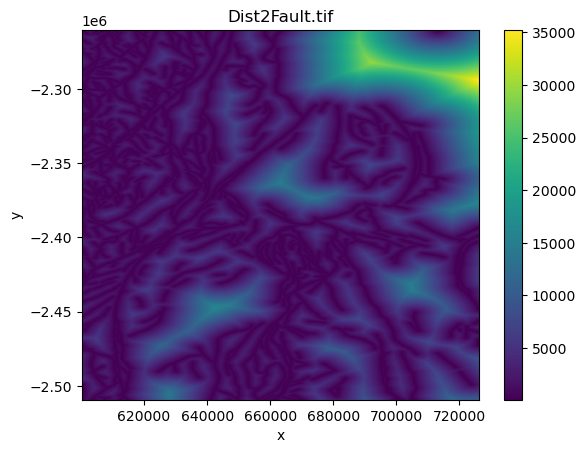

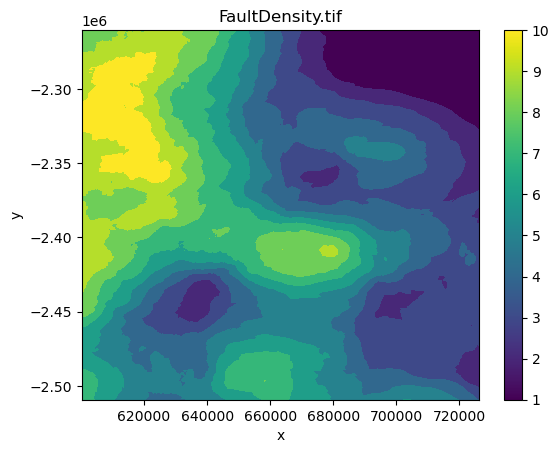

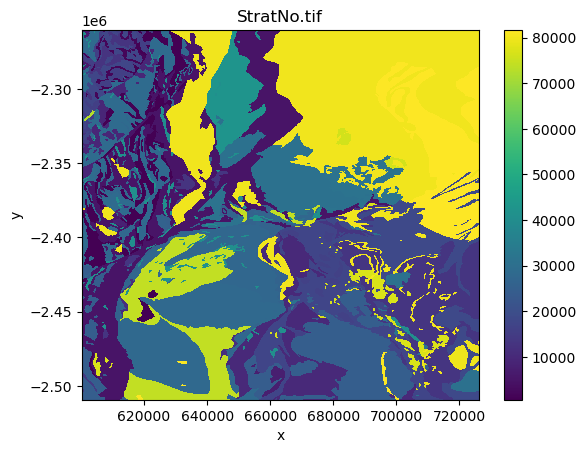

In [55]:
import matplotlib.pyplot as plt
for d in data:
    fig, ax = plt.subplots()
    data[d].plot(ax=ax)
    plt.title(d)

In [56]:
for d in data:
    print(data[d].rio.bounds(), data[d].rio.crs, data[d].rio.resolution(), data[d].rio.nodata, data[d].dtype, d)

(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float64 Dist2Breccia.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float64 Dist2Fault.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) None float32 FaultDensity.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float64 StratNo.tif


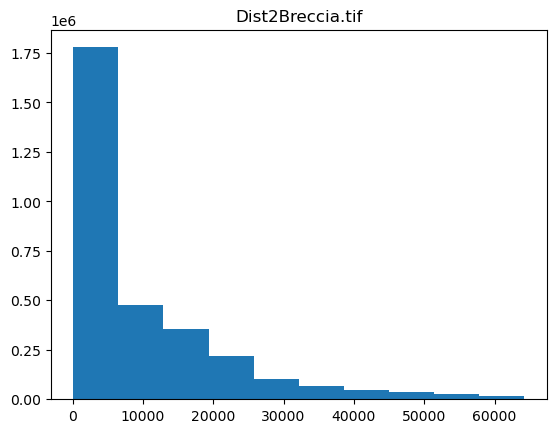

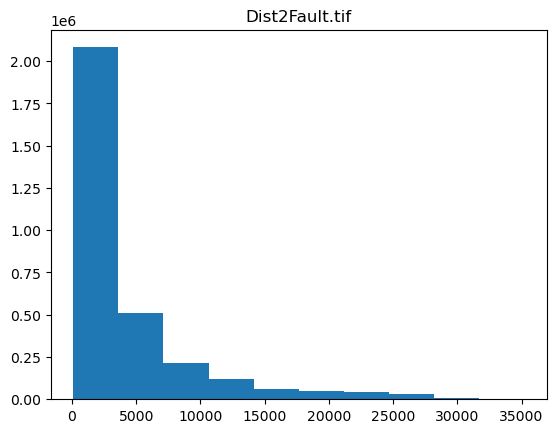

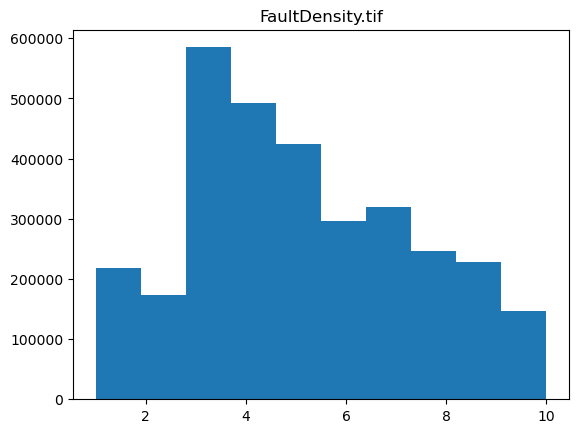

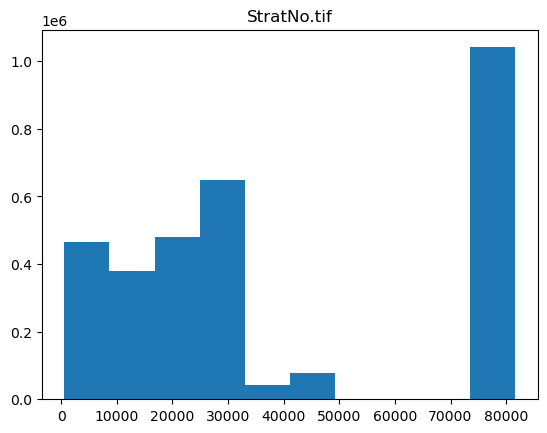

In [44]:
for d in data:
    fig, ax = plt.subplots()
    xr.plot.hist(data[d])
    plt.title(d)

In [57]:
iocg = gpd.read_file(r'TESTDATA\\CalculateWeights\\IOCG_Deposits.shp')

In [58]:
iocg

,Deposit,Status,Longitude,Latitude,Deposit_ty,Cu__Mt_,Zn__Mt_,Pb__Mt_,Ag__kt_,Au__t_,Source,DepositID,geometry
0,Abdy,Occurrence,139.951133,-20.611369,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (616378.824 -2374950.957)
1,Ace,Occurrence,140.777467,-20.984300,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (699675.507 -2420252.094)
2,Airport Prospect,Occurrence,140.181569,-20.303114,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (641895.388 -2342211.513)
3,Amethyst Castle,Occurrence,140.456531,-21.623617,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (662964.602 -2488687.592)
4,Artemis,Occurrence,140.798736,-20.980133,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (701893.908 -2419913.133)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Woomera,Occurrence,140.292400,-20.966156,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (649742.725 -2415655.053)
254,Kuridala,Occurrence,140.506000,-21.275150,IOCG,0.05,0.0,NaN,NaN,NaN,"Hoggard et al., 2020",1,POINT (670021.259 -2450706.873)
255,Merlin,Occurrence,140.492600,-21.662000,IOCG,0.03,0.0,NaN,NaN,NaN,"Hoggard et al., 2020",1,POINT (666447.214 -2493089.573)
256,Monakoff,Occurrence,140.688500,-20.625000,IOCG,0.03,0.0,NaN,NaN,NaN,"Hoggard et al., 2020",1,POINT (692602.422 -2380289.251)


<Axes: >

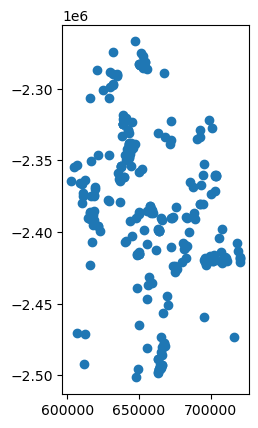

In [49]:
iocg.plot()

In [285]:
freqTable = {}
for d in data:
    freqTable[d] = data[d].groupby(data[d]).count()
    freqTable[d] = freqTable[d].to_dataframe()
    #print(freqTable[d].columns)
    freqTable[d].columns = ['spatial_ref','count']
    freqTable[d] = freqTable[d].reset_index()
    

In [283]:
for d in freqTable:
    print(d, freqTable[d])

Dist2Breccia.tif        group  spatial_ref   count
0      100.0            0  637030
1      200.0            0   44311
2      300.0            0   47127
3      400.0            0   39571
4      500.0            0   44427
..       ...          ...     ...
637  63800.0            0      58
638  63900.0            0      43
639  64000.0            0      28
640  64100.0            0      15
641  64200.0            0       3

[642 rows x 3 columns]
Dist2Fault.tif        group  spatial_ref   count
0      100.0            0  145305
1      200.0            0   95106
2      300.0            0  106895
3      400.0            0   90653
4      500.0            0  109910
..       ...          ...     ...
347  34800.0            0      18
348  34900.0            0      17
349  35000.0            0       9
350  35100.0            0       8
351  35200.0            0       1

[352 rows x 3 columns]
FaultDensity.tif    group  spatial_ref   count
0    1.0            0  217568
1    2.0            0  1737

In [214]:
depSig = {}
for d in data:
    depSig[d] = location_sample(iocg, data[d], 'Deposit')

In [215]:
valCount = {}
for d in depSig:
    print(d)
    valCount[d] = freqTable[d].merge(depSig[d], left_on="group",right_on="group")

Dist2Breccia.tif
Dist2Fault.tif
FaultDensity.tif
StratNo.tif


In [216]:
valCount2 = {}
for d in valCount:
    gb = valCount[d].groupby('group').count().reset_index()
    gb = gb[['group','count']]
    gb.columns = ['value','n']
    valCount2[d] = gb


In [286]:
freqTable2 = {}
for d in freq_table:
    freqTable2[d] = freq_table[d].merge(valCount2[d], left_on="group",right_on="value", how="left")
    freqTable2[d].fillna(0, inplace=True)

In [287]:
freqTableD = {}
for d in freq_table:
    freqTableD[d] = freqTable2[d].sort_values(by='group',ascending=False)

In [288]:
freqTable2['Dist2Breccia.tif']

,group,spatial_ref,count,value,n
0,100.0,0,637030,100.0,103.0
1,200.0,0,44311,200.0,13.0
2,300.0,0,47127,300.0,6.0
3,400.0,0,39571,400.0,6.0
4,500.0,0,44427,500.0,7.0
...,...,...,...,...,...
637,63800.0,0,58,0.0,0.0
638,63900.0,0,43,0.0,0.0
639,64000.0,0,28,0.0,0.0
640,64100.0,0,15,0.0,0.0


In [290]:
freqTableD['FaultDensity.tif']

,group,spatial_ref,count,value,n
9,10.0,0,146466,10.0,5.0
8,9.0,0,227565,9.0,17.0
7,8.0,0,247123,8.0,40.0
6,7.0,0,320305,7.0,73.0
5,6.0,0,297054,6.0,52.0
4,5.0,0,424177,5.0,24.0
3,4.0,0,492049,4.0,27.0
2,3.0,0,585125,3.0,20.0
1,2.0,0,173701,0.0,0.0
0,1.0,0,217568,0.0,0.0


In [291]:
freqTableD['Dist2Breccia.tif']

,group,spatial_ref,count,value,n
641,64200.0,0,3,0.0,0.0
640,64100.0,0,15,0.0,0.0
639,64000.0,0,28,0.0,0.0
638,63900.0,0,43,0.0,0.0
637,63800.0,0,58,0.0,0.0
...,...,...,...,...,...
4,500.0,0,44427,500.0,7.0
3,400.0,0,39571,400.0,6.0
2,300.0,0,47127,300.0,6.0
1,200.0,0,44311,200.0,13.0


In [223]:
#pixel size in km

class_km2 = [data[d].rio.resolution()[0] / 1000, abs(data[d].rio.resolution()[1] / 1000)]  #pos y value
class_km2

[0.1, 0.1]

In [302]:
#descending, ascending, categorical
## need to max this dataclass list
dataclass = ['a','a','d','c']
colnames = ["CLASS", "CLASS_AREA", "AREA_SQ_KM", "AREA_UNITS", "NO_POINTS", "WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC", "GEN_CLASS", "WEIGHT", "W_STD"]

In [303]:
makeWts = {}

for d in freqTable2:
    makeWts[d] = pd.DataFrame(columns=colnames)


In [307]:
#go through raster names and get corresponding class - make part of setup dict?

for index, d in enumerate(data.keys()):

    dc = dataclass[index]
    
    print(d, dc)
                          
    if dc != 'c':
        print(d, dc)
        if dc == 'd': ##doing the decending versions  . e.g. freqTableD
            makeWts[d]['CLASS'] = freqTableD[d]['group']
            makeWts[d]['CLASS_AREA'] = freqTableD[d]['count'] * class_km2[0]  * class_km2[1]
            makeWts[d]['AREA_SQ_KM'] = freqTableD[d]['count'] * class_km2[0]  * class_km2[1]                                                         
            makeWts[d]['AREA_UNITS'] = freqTableD[d]['count'] * class_km2[0]  * unitArea
            makeWts[d]['NO_POINTS'] = freqTableD[d]['n']

            makeWts[d]['AREA_SQ_KM'] = makeWts[d]['AREA_SQ_KM'].cumsum()
            makeWts[d]['AREA_UNITS'] = makeWts[d]['AREA_SQ_KM'] * unitArea
            makeWts[d]['NO_POINTS'] = makeWts[d]['NO_POINTS'].cumsum()

        if dc == 'a': ##doing the ascending versions

            makeWts[d]['CLASS'] = freqTable2[d]['group']
            makeWts[d]['CLASS_AREA'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]
            makeWts[d]['AREA_SQ_KM'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]                                                         
            makeWts[d]['AREA_UNITS'] = freqTable2[d]['count'] * class_km2[0]  * unitArea
            makeWts[d]['NO_POINTS'] = freqTable2[d]['n']

            makeWts[d]['AREA_SQ_KM'] = makeWts[d]['AREA_SQ_KM'].cumsum()
            makeWts[d]['AREA_UNITS'] = makeWts[d]['AREA_SQ_KM'] * unitArea
            makeWts[d]['NO_POINTS'] = makeWts[d]['NO_POINTS'].cumsum()
         
        
        makeWts[d]['s'] = makeWts[d]['AREA_UNITS'].max()
        makeWts[d]['b'] = makeWts[d]['AREA_UNITS']
        makeWts[d]['ds'] = iocg.shape[0]
        makeWts[d]['db'] = makeWts[d]['NO_POINTS']

        makeWts[d]['priorprob'] = makeWts[d]['ds'] / makeWts[d]['s']

        for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
            makeWts[d].loc[makeWts[d]['db'] == 0, c] = 0

        makeWts[d].loc[makeWts[d]['db'] == makeWts[d]['ds'], 'db'] = makeWts[d]['db'] - 0.99

        makeWts[d].loc[(makeWts[d]['s'] - makeWts[d]['db']) <= (makeWts[d]['ds'] - makeWts[d]['db']), 'b'] \
            = makeWts[d]['s'] + makeWts[d]['db'] - makeWts[d]['ds'] - 0.99

        makeWts[d].loc[(makeWts[d]['b'] - makeWts[d]['db']) <= 0.0, 'b'] = makeWts[d]['db'] + 1

        makeWts[d]['pbd'] = makeWts[d]['db'] / makeWts[d]['ds']
        makeWts[d]['pbdb'] = (makeWts[d]['b'] - makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
        makeWts[d]['ls'] = makeWts[d]['pbd'] / makeWts[d]['pbdb']
        makeWts[d]['wp'] = np.log(makeWts[d]['ls'])
        makeWts[d]['WPLUS'] = makeWts[d]['wp']    

        makeWts[d]['vp'] = (1.0 / makeWts[d]['db']) + (1.0 / (makeWts[d]['b'] - makeWts[d]['db']) )
        makeWts[d]['sp'] = np.sqrt(makeWts[d]['vp'])          
        makeWts[d]['S_WPLUS'] = makeWts[d]['sp']    

        makeWts[d]['pbbd'] = (makeWts[d]['ds'] - makeWts[d]['db']) / makeWts[d]['ds']
        makeWts[d]['pbbdb'] = (makeWts[d]['s'] - makeWts[d]['b'] - makeWts[d]['ds'] + makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
        makeWts[d]['ln1'] = makeWts[d]['pbbd'] / makeWts[d]['pbbdb']
        makeWts[d]['wm'] = np.log(makeWts[d]['ln1'])
        makeWts[d]['WMINUS'] = makeWts[d]['wm']    

        makeWts[d]['vm'] = (1.0 / (makeWts[d]['ds'] - makeWts[d]['db'])) + (1.0 / (makeWts[d]['s'] - makeWts[d]['b']  - makeWts[d]['ds'] +- makeWts[d]['db']) ) 
        makeWts[d]['sm'] = np.sqrt(makeWts[d]['vm'])          
        makeWts[d]['S_WMINUS'] = makeWts[d]['sm']    

        makeWts[d]['c'] = makeWts[d]['wp'] - makeWts[d]['wm']
        makeWts[d]['CONTRAST'] = makeWts[d]['c']

        makeWts[d]['sc'] = np.sqrt(makeWts[d]['vp'] + makeWts[d]['vm'])
        makeWts[d]['S_CONTRAST'] = makeWts[d]['sc']
        makeWts[d]['STUDC'] = makeWts[d]['c'] / makeWts[d]['sc']    

        maxConf = makeWts[d]['STUDC'].idxmax()
        maxCont = makeWts[d]['CONTRAST'].idxmax()

        confCont = 2 ## user supplied

        if maxConf < confCont:
            makeWts[d]['GEN_CLASS'] = 999
            makeWts[d]['WEIGHT'] = 0.0
            makeWts[d]['W_STD'] = 0.0
        else:
            makeWts[d].loc[(makeWts[d]['CLASS'] <= makeWts[d]['CLASS'].max()) & (makeWts[d]['CONTRAST'] <= makeWts[d]['CONTRAST'].max()) \
                          & (makeWts[d]['STUDC'] <= makeWts[d]['STUDC'].max()) & (makeWts[d].index <= maxCont)\
                          , ['GEN_CLASS','WEIGHT','W_STD']]  = [2, makeWts[d].iloc[maxCont]['WPLUS'], makeWts[d].iloc[maxCont]['S_WPLUS']]

            makeWts[d].loc[(makeWts[d]['CLASS'] <= makeWts[d]['CLASS'].max()) & (makeWts[d]['CONTRAST'] <= makeWts[d]['CONTRAST'].max()) \
                          & (makeWts[d]['STUDC'] <= makeWts[d]['STUDC'].max()) & (makeWts[d].index > maxCont)\
                          , ['GEN_CLASS','WEIGHT','W_STD']]  = [2, makeWts[d].iloc[maxCont]['WMINUS'], makeWts[d].iloc[maxCont]['S_WMINUS']]

    

    if dc == 'c':
        makeWts[d]['CLASS'] = freqTable2[d]['group']
        makeWts[d]['CLASS_AREA'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]
        makeWts[d]['AREA_SQ_KM'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]                                                         
        makeWts[d]['AREA_UNITS'] = freqTable2[d]['count'] * class_km2[0]  * unitArea
        makeWts[d]['NO_POINTS'] = freqTable2[d]['n']
        
        makeWts[d]['s'] = makeWts[d]['AREA_UNITS'].sum()
        makeWts[d]['b'] = makeWts[d]['AREA_UNITS']
        makeWts[d]['ds'] = iocg.shape[0]
        makeWts[d]['db'] = makeWts[d]['NO_POINTS']
        
        makeWts[d]['priorprob'] = makeWts[d]['ds'] / makeWts[d]['s']

        for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
            makeWts[d].loc[makeWts[d]['db'] == 0, c] = 0
        
        makeWts[d].loc[makeWts[d]['db'] == makeWts[d]['ds'], 'db'] = makeWts[d]['db'] - 0.99

        makeWts[d].loc[makeWts[d]['db'] == 0.001, 'db'] = makeWts[d]['ds'] - 0.99
        

        

    #break  ## just test one


Dist2Breccia.tif a
Dist2Breccia.tif a
Dist2Fault.tif a
Dist2Fault.tif a
FaultDensity.tif d
FaultDensity.tif d
StratNo.tif c


C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [306]:
makeWts

{'Dist2Breccia.tif':        CLASS  CLASS_AREA  AREA_SQ_KM  AREA_UNITS  NO_POINTS     WPLUS  \
 0      100.0     6370.30     6370.30     6370.30      103.0  0.707334   
 1      200.0      443.11     6813.41     6813.41      116.0  0.756197   
 2      300.0      471.27     7284.68     7284.68      122.0  0.737194   
 3      400.0      395.71     7680.39     7680.39      128.0  0.730409   
 4      500.0      444.27     8124.66     8124.66      135.0  0.725514   
 ..       ...         ...         ...         ...        ...       ...   
 637  63800.0        0.58    31310.44    31310.44      258.0 -0.003784   
 638  63900.0        0.43    31310.87    31310.87      258.0 -0.003798   
 639  64000.0        0.28    31311.15    31311.15      258.0 -0.003807   
 640  64100.0        0.15    31311.30    31311.30      258.0 -0.003812   
 641  64200.0        0.03    31311.33    31311.33      258.0 -0.003813   
 
       S_WPLUS    WMINUS  S_WMINUS  CONTRAST  S_CONTRAST     STUDC GEN_CLASS  \
 0    0.09

In [251]:
dfmakeWts['s'] = dfmakeWts['AREA_UNITS'].max()
dfmakeWts['b'] = dfmakeWts['AREA_UNITS']
dfmakeWts['ds'] = iocg.shape[0]
dfmakeWts['db'] = dfmakeWts['NO_POINTS']

df['priorprob'] = dfmakeWts['ds'] / dfmakeWts['s']

In [252]:
for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
    dfmakeWts.loc[dfmakeWts['db'] == 0, c] = 0
    
dfmakeWts.loc[dfmakeWts['db'] == dfmakeWts['ds'], 'db'] = dfmakeWts['db'] - 0.99

dfmakeWts.loc[(dfmakeWts['db'] - dfmakeWts['db']) <= (dfmakeWts['ds'] - dfmakeWts['db']), 'b'] = dfmakeWts['b'] + dfmakeWts['db'] - dfmakeWts['ds'] - 0.99

dfmakeWts.loc[(dfmakeWts['b'] - dfmakeWts['db']) <= 0.0, 'b'] = dfmakeWts['db'] + 1
    

In [253]:
dfmakeWts['pbd'] = dfmakeWts['db'] / dfmakeWts['ds']
dfmakeWts['pbdb'] = (dfmakeWts['b'] - dfmakeWts['db']) / (dfmakeWts['s'] - dfmakeWts['ds'])
dfmakeWts['ls'] = dfmakeWts['pbd'] / dfmakeWts['pbdb']
dfmakeWts['wp'] = np.log(dfmakeWts['ls'])

dfmakeWts['WPLUS'] = dfmakeWts['wp']

In [254]:
dfmakeWts['vp'] = (1.0 / dfmakeWts['db']) + (1.0 / (dfmakeWts['b'] - dfmakeWts['db']) )
dfmakeWts['sp'] = np.sqrt(dfmakeWts['vp'])          
                                             
dfmakeWts['S_WPLUS'] = dfmakeWts['sp']

In [255]:
dfmakeWts['pbbd'] = (dfmakeWts['ds'] - dfmakeWts['db']) / dfmakeWts['ds']
dfmakeWts['pbbdb'] = (dfmakeWts['s'] - dfmakeWts['b'] - dfmakeWts['ds'] + dfmakeWts['db']) / (dfmakeWts['s'] - dfmakeWts['ds'])
dfmakeWts['ln1'] = dfmakeWts['pbbd'] / dfmakeWts['pbbdb']
dfmakeWts['wm'] = np.log(dfmakeWts['ln1'])

dfmakeWts['WMINUS'] = dfmakeWts['wm']

In [256]:
dfmakeWts['vm'] = (1.0 / (dfmakeWts['ds'] - dfmakeWts['db'])) + (1.0 / (dfmakeWts['s'] - dfmakeWts['b']  - dfmakeWts['ds'] +- dfmakeWts['db']) ) 
dfmakeWts['sm'] = np.sqrt(dfmakeWts['vm'])          
                                             
dfmakeWts['S_WMINUS'] = dfmakeWts['sm']

C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [257]:
dfmakeWts['c'] = dfmakeWts['wp'] - dfmakeWts['wm']

dfmakeWts['CONTRAST'] = dfmakeWts['c']

In [258]:
dfmakeWts['sc'] = np.sqrt(dfmakeWts['vp'] + dfmakeWts['vm'])

dfmakeWts['S_CONTRAST'] = dfmakeWts['sc']
dfmakeWts['STUDC'] = dfmakeWts['c'] / dfmakeWts['sc']

C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [262]:
maxConf = dfmakeWts['STUDC'].idxmax()
maxCont = dfmakeWts['CONTRAST'].idxmax()

confCont = 2 ## user supplied

if maxConf < confCont:
    dfmakeWts['GEN_CLASS'] = 999
    dfmakeWts['WEIGHT'] = 0.0
    dfmakeWts['W_STD'] = 0.0
else:
    dfmakeWts.loc[(dfmakeWts['CLASS'] <= dfmakeWts['CLASS'].max()) & (dfmakeWts['CONTRAST'] <= dfmakeWts['CONTRAST'].max()) \
                  & (dfmakeWts['STUDC'] <= dfmakeWts['STUDC'].max()) & (dfmakeWts.index <= maxCont)\
                  , ['GEN_CLASS','WEIGHT','W_STD']]  = [2, dfmakeWts.iloc[maxCont]['WPLUS'], dfmakeWts.iloc[maxCont]['S_WPLUS']]

    dfmakeWts.loc[(dfmakeWts['CLASS'] <= dfmakeWts['CLASS'].max()) & (dfmakeWts['CONTRAST'] <= dfmakeWts['CONTRAST'].max()) \
                  & (dfmakeWts['STUDC'] <= dfmakeWts['STUDC'].max()) & (dfmakeWts.index > maxCont)\
                  , ['GEN_CLASS','WEIGHT','W_STD']]  = [2, dfmakeWts.iloc[maxCont]['WMINUS'], dfmakeWts.iloc[maxCont]['S_WMINUS']]
    

In [271]:
makeWts

{'Dist2Breccia.tif':        CLASS  CLASS_AREA  AREA_SQ_KM  AREA_UNITS  NO_POINTS WPLUS S_WPLUS  \
 0      100.0     6370.30     6370.30     6370.30      103.0   NaN     NaN   
 1      200.0      443.11     6813.41     6813.41      116.0   NaN     NaN   
 2      300.0      471.27     7284.68     7284.68      122.0   NaN     NaN   
 3      400.0      395.71     7680.39     7680.39      128.0   NaN     NaN   
 4      500.0      444.27     8124.66     8124.66      135.0   NaN     NaN   
 ..       ...         ...         ...         ...        ...   ...     ...   
 637  63800.0        0.58    31310.44    31310.44      258.0   NaN     NaN   
 638  63900.0        0.43    31310.87    31310.87      258.0   NaN     NaN   
 639  64000.0        0.28    31311.15    31311.15      258.0   NaN     NaN   
 640  64100.0        0.15    31311.30    31311.30      258.0   NaN     NaN   
 641  64200.0        0.03    31311.33    31311.33      258.0   NaN     NaN   
 
     WMINUS S_WMINUS CONTRAST S_CONTRAST S

In [272]:
dfmakeWts

,CLASS,CLASS_AREA,AREA_SQ_KM,AREA_UNITS,NO_POINTS,WPLUS,S_WPLUS,WMINUS,S_WMINUS,CONTRAST,S_CONTRAST,STUDC,GEN_CLASS,WEIGHT,W_STD
0,585.0,997.14,997.14,997.14,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1621.0,101.41,1098.55,1098.55,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4727.0,3443.14,4541.69,4541.69,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6432.0,17.47,4559.16,4559.16,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7245.0,60.89,4620.05,4620.05,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,81280.0,4.83,29497.79,29497.79,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,81284.0,27.10,29524.89,29524.89,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,81639.0,46.65,29571.54,29571.54,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,81640.0,141.26,29712.80,29712.80,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
dfmakeWts

,CLASS,CLASS_AREA,AREA_SQ_KM,AREA_UNITS,NO_POINTS,WPLUS,S_WPLUS,WMINUS,S_WMINUS,CONTRAST,S_CONTRAST,STUDC,GEN_CLASS,WEIGHT,W_STD,s,b,ds,db,pbd,pbdb,ls,wp,vp,sp,pbbd,pbbdb,ln1,wm,vm,sm,c,sc
0,100.0,6370.30,6370.30,6370.30,103.0,0.707334,0.099360,-0.290382,0.080573,0.997717,0.127923,7.799326,2,0.051006,0.06265,31311.33,6214.31,258,103.00,0.399225,0.196800,2.028576,0.707334,0.009872,0.099360,0.600775,0.803200,0.747978,-0.290382,0.006492,0.080573,0.997717,0.127923
1,200.0,443.11,6813.41,6813.41,116.0,0.756197,0.093666,-0.360055,0.084163,1.116252,0.125923,8.864528,2,0.051006,0.06265,31311.33,6670.42,258,116.00,0.449612,0.211070,2.130160,0.756197,0.008773,0.093666,0.550388,0.788930,0.697638,-0.360055,0.007083,0.084163,1.116252,0.125923
2,300.0,471.27,7284.68,7284.68,122.0,0.737194,0.091318,-0.383803,0.085994,1.120998,0.125435,8.936851,2,0.051006,0.06265,31311.33,7147.69,258,122.00,0.472868,0.226246,2.090063,0.737194,0.008339,0.091318,0.527132,0.773754,0.681265,-0.383803,0.007395,0.085994,1.120998,0.125435
3,400.0,395.71,7680.39,7680.39,128.0,0.730409,0.089147,-0.412318,0.087949,1.142727,0.125229,9.125089,2,0.051006,0.06265,31311.33,7549.40,258,128.00,0.496124,0.238989,2.075930,0.730409,0.007947,0.089147,0.503876,0.761011,0.662114,-0.412318,0.007735,0.087949,1.142727,0.125229
4,500.0,444.27,8124.66,8124.66,135.0,0.725514,0.086802,-0.448689,0.090409,1.174203,0.125333,9.368696,2,0.051006,0.06265,31311.33,8000.67,258,135.00,0.523256,0.253296,2.065792,0.725514,0.007535,0.086802,0.476744,0.746704,0.638464,-0.448689,0.008174,0.090409,1.174203,0.125333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,63800.0,0.58,31310.44,31310.44,258.0,-0.003784,0.062635,4.149180,1.004066,-4.152964,1.006018,-4.128122,2,-2.623209,1.000437,31311.33,31308.46,258,257.01,0.996163,0.999939,0.996223,-0.003784,0.003923,0.062635,0.003837,0.000061,63.381982,4.149180,1.008148,1.004066,-4.152964,1.006018
638,63900.0,0.43,31310.87,31310.87,258.0,-0.003798,0.062635,4.408888,1.004067,-4.412686,1.006018,-4.386287,2,-2.623209,1.000437,31311.33,31308.89,258,257.01,0.996163,0.999953,0.996209,-0.003798,0.003923,0.062635,0.003837,0.000047,82.178018,4.408888,1.008150,1.004067,-4.412686,1.006018
639,64000.0,0.28,31311.15,31311.15,258.0,-0.003807,0.062635,4.623448,1.004067,-4.627255,1.006019,-4.599570,2,-2.623209,1.000437,31311.33,31309.17,258,257.01,0.996163,0.999962,0.996200,-0.003807,0.003923,0.062635,0.003837,0.000038,101.844553,4.623448,1.008151,1.004067,-4.627255,1.006019
640,64100.0,0.15,31311.30,31311.30,258.0,-0.003812,0.062635,4.760649,1.004068,-4.764461,1.006019,-4.735953,2,-2.623209,1.000437,31311.33,31309.32,258,257.01,0.996163,0.999967,0.996196,-0.003812,0.003923,0.062635,0.003837,0.000033,116.821693,4.760649,1.008152,1.004068,-4.764461,1.006019
